# Friendly Playoff Pool Stats

## Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#font = {'family' : 'helvetica',  # need to download helvetica
#        'size'   : 12}

font = {'family' : 'serif',
        'size'   : 12}
mpl.rc('font', **font)

In [3]:
cd Players_records/

/Users/daviddeepwell/Documents/Hockey/Hockey Pool/Playoffs/Players_records


## Define Functions

### Data manipulation functions

In [4]:
# Point values
def point_values( year ):
    if year <= 2007:
        T = 10
        G = 7
        # Stanley Cup points
        W = 25
        R = 15
        WR = W+R
        WF = RF = FF = N = '-'
        return [T, G, T, G, T, G, T, G, [W, R, WR, WF, RF, FF, N]]
    if  2008 <= year <= 2014:
        T = 7
        G = 10
        # Stanley Cup points
        W = 25
        R = 15
        WR = W+R
        WF = RF = FF = N= '-'
        return [T, G, T, G, T, G, T, G, [W, R, WR, WF, RF, FF, N]]
    if  year >= 2015:
        T = 10
        G = 5
        # Stanley Cup points
        W = 15
        R = 10
        WR = W+R
        WF = RF = FF = N = '-'
        return [T, G, T, G, T, G, 2*T, 2*G, [W, R, WR, WF, RF, FF, N]]

In [5]:
# load data for a given name
def load_data( name ):
    Nnames = len(names)
    name_val = dict( zip(names, range(Nnames)))
    nn = name_val[name]
    files = os.listdir('.')
    file = files[nn]
    fdata = pd.read_csv(file, sep=' ')
    fdata.index = ['T1','G1','O1','T2','G2','O2','T3','G3','O3','T4','G4','O4','SC']
    data = pd.DataFrame(fdata)
    data.name = name
    return data

In [6]:
def convert_to_pts( name ):
    # convert header to int
    data = data_raw[name]
    header_int = data.columns.astype(int)
    data.columns = header_int
    # convert Stanley cup strings to values
    years = header_int
    for year in years:
        pts = point_values( year )
        SC = pts[-1]
        if year == years[0]:
            d = {year : data[year].replace(to_replace=
                {'W': SC[0], 'R': SC[1], 'WR': SC[2], 'WF': SC[3], 'RF': SC[4], 'FF': SC[5], 'N': SC[6]})}
            df = pd.DataFrame(d)
        else:
            df = df.assign(year=data[year].replace(to_replace=
                {'W': SC[0], 'R': SC[1], 'WR': SC[2], 'WF': SC[3], 'RF': SC[4], 'FF': SC[5], 'N': SC[6]}))
            df = df.rename(index=str, columns = {'year': year})
    # convert strings of numbers to int
    data = df.apply(pd.to_numeric, errors='coerce')
    return data

In [7]:
# convert nans to zero where appropriate
def convert_to_zero( name ):
    data = data_val[name]
    for year in data.columns:
        for ind in [2, 5, 8, 11]:
            if not (np.isnan(data[year][ind-2]) and np.isnan(data[year][ind-1]) and np.isnan(data[year][ind])):
                if np.isnan(data[year][ind-2]):
                    data[year][ind-2] = 0
                if np.isnan(data[year][ind-1]):
                    data[year][ind-1] = 0
                if np.isnan(data[year][ind]):
                    data[year][ind] = 0
    return data

In [8]:
# make table of points in each round
def get_round_pts( name ):
    data = data_val[name]
    years = data.columns
    for year in years:
        pts = point_values( year )
        scr = [np.nan]*5
        for ind in [0, 3, 6, 9, 12]:
            if ind < 12:
                scr[ind//3] = np.dot(data[year].values[ind:ind+3], [pts[ind//3*2], pts[ind//3*2+1], 1])
            elif ind == 12:
                scr[ind//3] = data[year].values[ind]
        if year == years[0]:
            d = {year : pd.Series(scr, index=['R1', 'R2', 'R3', 'R4', 'SC'])}
            df = pd.DataFrame(d)
        else:
            df = df.assign(year=scr)
            df = df.rename(index=str, columns = {'year': year})
        df.name = 'Points - '+name
    return df

In [9]:
# Make table of points for a given year
def mk_year_table( year ):
    for name in names:
        if year in data_pts[name].columns:
            d = data_pts[name][year]
            d.name = name
            if not 'df' in locals():
                df = pd.DataFrame(d)
            else:
                df = df.assign(name=d)
                df = df.rename(index=str, columns = {'name': name})
    df_sorted = df.reindex_axis(df.sum(axis=0).sort_values(ascending=True).index, axis=1)
    df_sorted.name = 'Points - '+str(year)
    return df_sorted

In [10]:
def find_winner( year ):
    df = mk_year_table(year)
    return df.columns[-1]

In [11]:
def mk_SC_table():
    for name in names:
        data = data_raw[name]
        SC = data.loc['SC']
        WR = SC.str.count(r"WR$").sum();
        W  = SC.str.count(r"W$").sum();
        R  = SC.str.count(r"R$").sum();
        WF = SC.str.count(r"WF$").sum();
        RF = SC.str.count(r"RF$").sum();
        FF = SC.str.count(r"FF$").sum();
        N  = SC.str.count(r"N$").sum();
        atts = len(data.columns) - N
        scr = [WR, W, R, WF, RF, FF, atts]
        if not 'df' in locals():
            d = {name : pd.Series(scr, index=['WR', 'W', 'R', 'WF', 'RF', 'FF', 'attempts'])}
            df = pd.DataFrame(d)
        else:
            df = df.assign(name=scr)
            df = df.rename(index=str, columns = {'name': name})
    return df

In [12]:
def count_SC( cat, sort='Percentage' ):
    SC = mk_SC_table()
    col = SC.sort_values(cat, axis=1, ascending=False).loc[cat]
    df = pd.DataFrame(col)
    atts = SC.loc['attempts']
    df = df.assign(Attempts=atts)
    perc = df[cat]/df['Attempts']
    df = df.assign(Percentage=perc)
    if sort == 'Percentage':
        df.sort_values(['Percentage', 'Attempts'], ascending=[False, True], inplace=True)
    elif sort == 'Total':
        df.sort_values([cat, 'Attempts'], ascending=[False, True], inplace=True)
    return df

In [13]:
def winner_table( year ):
    for year in range(2006, year+1):
        yr = mk_year_table(year)
        winner = yr.columns[-1]
        ser = yr[winner]
        ser.name = ser.name+' - '+str(year)
        #ser = ser.append(pd.Series([2006], index=['year']))
        if not 'df' in locals():
            df = pd.DataFrame(ser)
        else:
            df = df.assign(name=ser)
            df = df.rename(index=str, columns = {'name': ser.name})
    return df

### Plotting functions

In [14]:
def make_plot(data, save=False, text=True, legend=True):
    # make labels for each column of data (row of bar graph)
    labels = data.columns
    N_labs = len(labels)
    if not hasattr(data, 'name'):
        data.name = 'Winners'
    name_str = data.name
    name = name_str.split(" - ")[-1]
    if labels.dtype == np.array([object()]).dtype:
        add_asterix = False
    else:
        add_asterix = True
    winner = False

    # colours to use in each segment
    colors = ['#95c4e8','#a3e6be','#fbee9d','#fbbf9d','#e29dfb']

    # set-up figure
    fig = plt.figure(figsize=(12,0.5*N_labs))
    ax = fig.add_subplot(111)
    #plt.rc('text', usetex=false)
    #plt.rc('font', family='serif')
    patches = []
    a_bar = [0]*5

    rounds = ['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Stanley Cup']
    for label in labels:
        r = labels.get_loc(label) - labels.get_loc(labels[0])
        widths = data[label].values
        left = 0
        for ind in range(len(widths)):
            w = widths[ind]
            if not np.isnan(w):
                a_bar[ind] = ax.barh(r, w, align='center', left=left, edgecolor='black',
                    color=colors[ind],label=rounds[ind])
                patches.append(a_bar[ind])
                # add text
                patch = patches[-1][0] 
                bl = patch.get_xy()
                x = 0.5*patch.get_width() + bl[0]
                y = 0.5*patch.get_height() + bl[1]
                if text:
                    ax.text(x, y, "%d" % (w), ha='center',va='center')
                else:
                    ax.text(x, y, "%.2f" % (w), ha='center',va='center')
                left += w
            if ind == len(widths)-1:
                x = bl[0] + patch.get_width() + 6
                total = np.sum(np.ma.masked_invalid(widths))
                if text:
                    if add_asterix:
                        if find_winner(label) == name:
                            ax.text(x, y, "%d*" % (total), ha='center',va='center')
                            winner = True
                        else:
                            ax.text(x, y, "%d" % (total), ha='center',va='center')
                    else:
                        ax.text(x, y, "%d" % (total), ha='center',va='center')

    # set axis and add labels
    y_pos = np.arange(N_labs)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    #ax.set_xlabel('Points')
    plt.title(data.name)

    # remove plot lines
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.get_xaxis().set_ticks([])

    if legend:
        # Shrink current axis by 25%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])

        # remove unused elements of a_bar
        a_bar2 = list(filter(lambda a: a != 0, a_bar))
    
        # Put a legend to the right of the current axis
        if winner:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5),title='* Winner')
        else:
            plt.legend(handles=a_bar2, loc='center left',bbox_to_anchor=(1.05,0.5))
    
    # save figure
    if save:
        os.chdir('Figures')
        filename = data.name
        form = 'pdf'
        plt.savefig(filename+'.'+form, bbox_inches='tight', format=form)
        os.chdir('..')
    
    # display plot inline
    plt.show();

In [15]:
def plot_year( year, save=False ):
    df = mk_year_table( year )
    make_plot(df, save=save)

In [16]:
def plot_SC( cat, amount='Percentage' ):
    # amount = {'Percentage', 'Total'}
    if amount == 'Percentage':
        df = pd.DataFrame(count_SC(cat)['Percentage'])
    elif amount == 'Total':
        df = pd.DataFrame(count_SC(cat,sort='Total')[cat])
    df2 = df.T
    df2 = df2[df2.columns[::-1]]
    df2 = df2.drop('Sheldon',axis=1) # drop all nans (should improve)
    df2.name = 'SC '+cat+' - '+amount
    #if amount == 'Percentage':
    make_plot(df2, text=False, legend=False)
    #elif amount == 'Total':
    #    make_plot(df2, legend=False) # need to fix spacing

In [17]:
def winner_plot( year ):
    df = winner_table(year)
    make_plot(df)

## Load and plot data

In [18]:
# Find files and set-up variables
names = [file.split('.')[0] for file in os.listdir('.')]
# load data
data_raw = {name: load_data(name) for name in names}

In [19]:
cd ..

/Users/daviddeepwell/Documents/Hockey/Hockey Pool/Playoffs


In [20]:
# Convert raw data to numerical values (data_val) and points (data_pts)
data_val = {name: convert_to_pts(name)  for name in names}
data_val = {name: convert_to_zero(name) for name in names}
data_pts = {name: get_round_pts(name)   for name in names}

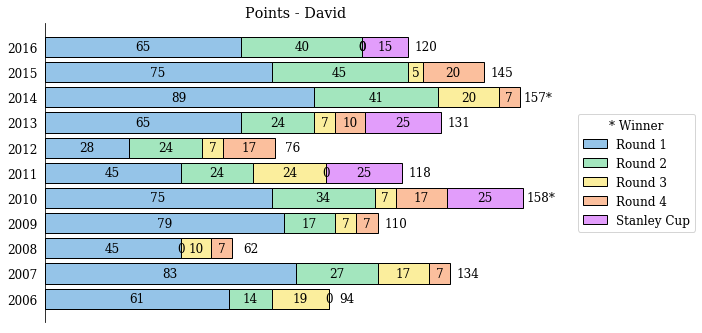

In [21]:
make_plot(data_pts['David'], save=True);

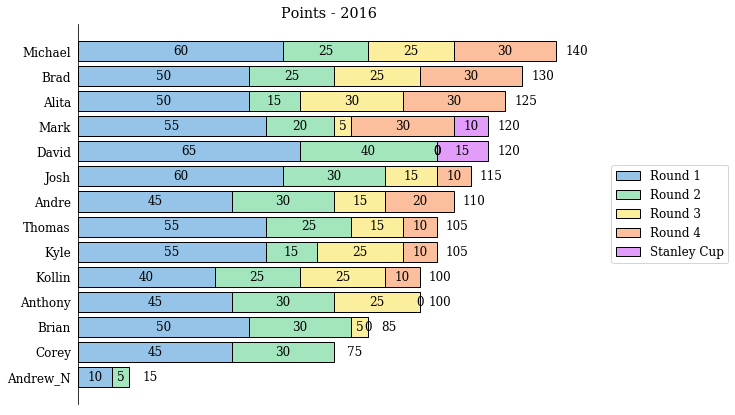

In [22]:
plot_year(2016, save=True)

## Work

In [23]:
count_SC('W',sort='Total')

,W,Attempts,Percentage
David,4,11,0.363636
Daniel,1,4,0.250000
Andrew,1,5,0.200000
Charmaine,1,5,0.200000
Mark,1,8,0.125000
Andre,1,8,0.125000
Michael,1,11,0.090909
Kollin,1,11,0.090909
Sheldon,0,0,NaN
Isaiah,0,1,0.000000


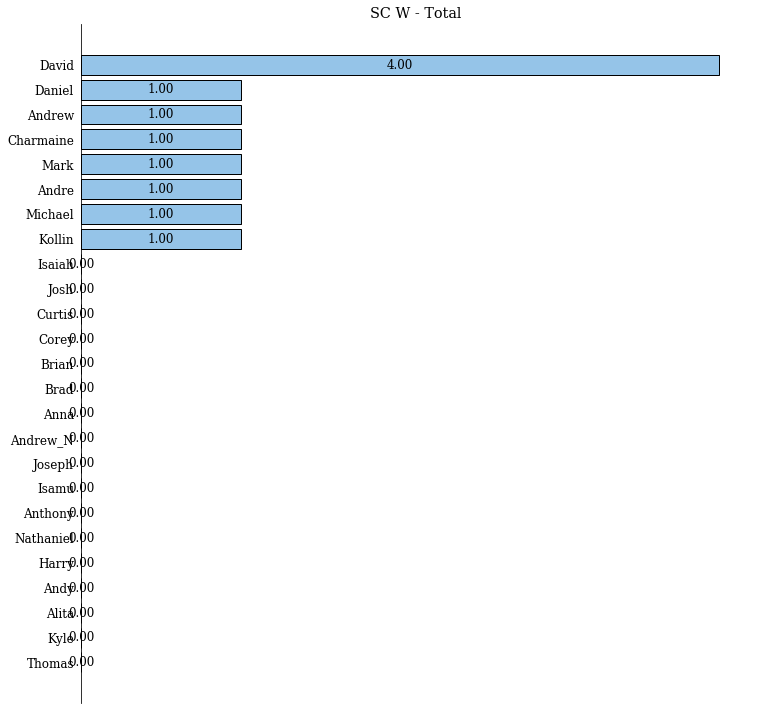

In [24]:
plot_SC('W',amount='Total')

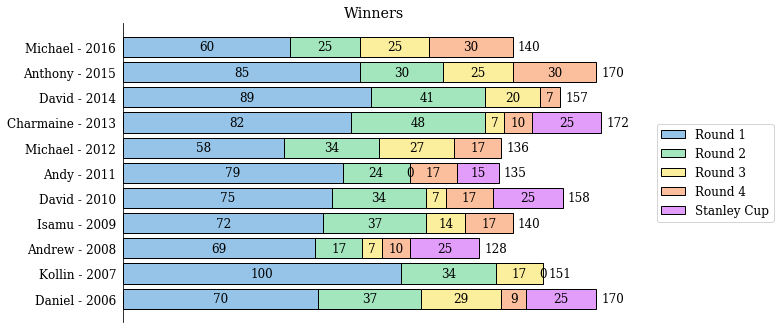

In [25]:
winner_plot(2016)

In [26]:
df = mk_year_table( 2016 )

In [27]:
df

,Andrew_N,Corey,Brian,Anthony,Kollin,Kyle,Thomas,Andre,Josh,David,Mark,Alita,Brad,Michael
R1,10.0,45.0,50.0,45.0,40.0,55.0,55.0,45.0,60.0,65.0,55.0,50.0,50.0,60.0
R2,5.0,30.0,30.0,30.0,25.0,15.0,25.0,30.0,30.0,40.0,20.0,15.0,25.0,25.0
R3,NaN,NaN,5.0,25.0,25.0,25.0,15.0,15.0,15.0,0.0,5.0,30.0,25.0,25.0
R4,NaN,NaN,0.0,0.0,10.0,10.0,10.0,20.0,10.0,0.0,30.0,30.0,30.0,30.0
SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,10.0,NaN,NaN,NaN


In [28]:
data_val

{'Alita':     2010  2011  2012  2013  2014  2015  2016
 T1   NaN   5.0   4.0   5.0   5.0   4.0   4.0
 G1   NaN   3.0   2.0   1.0   1.0   2.0   2.0
 O1   NaN   0.0   0.0   0.0   0.0   0.0   0.0
 T2   3.0   1.0   0.0   3.0   3.0   1.0   1.0
 G2   0.0   2.0   0.0   1.0   2.0   0.0   1.0
 O2   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 T3   0.0   2.0   0.0   1.0   NaN   1.0   2.0
 G3   0.0   0.0   1.0   0.0   NaN   1.0   2.0
 O3   0.0   0.0   0.0   0.0   NaN   0.0   0.0
 T4   0.0   0.0   1.0   1.0   NaN   0.0   1.0
 G4   1.0   1.0   1.0   1.0   NaN   0.0   1.0
 O4   0.0   0.0   0.0   0.0   NaN   0.0   0.0
 SC   NaN   NaN   NaN   NaN   NaN   NaN   NaN,
 'Andre':     2009  2010  2011  2012  2013  2014  2015  2016
 T1   6.0   6.0   5.0   6.0   7.0   6.0   6.0   4.0
 G1   2.0   4.0   3.0   1.0   3.0   3.0   2.0   1.0
 O1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
 T2   2.0   2.0   3.0   3.0   3.0   2.0   2.0   3.0
 G2   1.0   1.0   1.0   1.0   2.0   3.0   1.0   0.0
 O2   0.0   0.0   0.0   0